In [2]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
#import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/.julia/dev/iLQGameSolver/examples/Project.toml`


Pkg.Types.PkgError: `Revise` is a direct dependency, but does not appear in the manifest. If you intend `Revise` to be a direct dependency, run `Pkg.resolve()` to populate the manifest. Otherwise, remove `Revise` with `Pkg.rm("Revise")`. Finally, run `Pkg.instantiate()` again.

In [3]:
using Revise
using LinearAlgebra
using Plots
using SparseArrays
using ForwardDiff
using Random
using Test
using StaticArrays
using iLQGameSolver
using BenchmarkTools
using InvertedIndices

### 2D Point Mass Continous dynamics

The 2D point masses with mass $m=1\; \text{kg}$ are subject to input forces $F_{ext}$ and damping coefficient $c = 0.1\;[N \cdot \frac{s}{m}]$.


\begin{split}
\dot p &= v\\
\dot v &= -\frac{b}{m}v + \frac{1}{m}F_{ext}
\end{split}

#### Point Mass Discrete

The discrete time linear dynamics for two 2D point masses are as described below: 
$$\begin{equation}
    x_{t+1} = A_tx_t + B^1_tu^1_t + B^2_tu^2_t
\end{equation} $$
where the $A_t$ matrix is:
$$\begin{equation}
    A_t = \begin{bmatrix}   1 & 0 & h & 0 & 0 & 0 & 0 & 0               \\ 
                            0 & 1 & 0 & h & 0 & 0 & 0 & 0               \\ 
                            0 & 0 & 1-(c/m_1)*h & 0 & 0 & 0 & 0 & 0     \\ 
                            0 & 0 & 0 & 1-(c/m_1)*h & 0 & 0 & 0 & 0     \\
                            0 & 0 & 0 & 0 & 1 & 0 & h & 0               \\ 
                            0 & 0 & 0 & 0 & 0 & 1 & 0 & h               \\ 
                            0 & 0 & 0 & 0 & 0 & 0 & 1-(c/m_2)*h & 0     \\ 
                            0 & 0 & 0 & 0 & 0 & 0 & 0 & 1-(c/m_2)*h     \\ 
    \end{bmatrix}
\end{equation} $$
the $B^1_t$ and $B^2_t$ matrices are:
$$\begin{equation}
    B^1_t = \begin{bmatrix} 0 & 0       \\ 
                            0 & 0       \\ 
                            h/m_1 & 0   \\ 
                            0 & h/m_1   \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\
    \end{bmatrix},
    B^2_t = \begin{bmatrix} 0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            0 & 0       \\ 
                            h/m_2 & 0   \\ 
                            0 & h/m_2   \\
    \end{bmatrix}
\end{equation} $$
the $x_t$, $u^1_t$, and $u^2_t$ vectors are:
$$\begin{equation}
    x_t = \begin{bmatrix}   x_1         \\ 
                            y_1         \\ 
                            \dot{x}_1   \\ 
                            \dot{y}_1   \\ 
                            x_2 \\ y_2  \\ 
                            \dot{x}_2   \\ 
                            \dot{y}_2   \\
    \end{bmatrix},
    u^1_t = \begin{bmatrix} u^1_x   \\
                            u^1_y   \\
    \end{bmatrix},
    u^2_t = \begin{bmatrix} u^2_x   \\ 
                            u^2_y   \\ 
    \end{bmatrix}
\end{equation} $$

The variables $c$, $h$, $m_1$, and $m_2$ are the damping coefficients [N-s/m], time steps [s], mass of the first agent [kg], and mass of the second agent [kg], respectively.

$$\begin{bmatrix} S11 & S12 \\ S21 & S22 \end{bmatrix}
\begin{bmatrix} P1 \\ P2 \end{bmatrix} = 
\begin{bmatrix} Y1 \\ Y2 \end{bmatrix}$$

$$ \begin{bmatrix} R^{11} + (B^{1'} * V₁ * B^1) & (B^{1'} * V₁ * B^2) \\ (B^{2'} * V_2 * B^1) & R^{22} + (B^{2'} * V_2 * B^2) \end{bmatrix}$$

<!-- $$ \frac{d}{dt}x = Ax + \sum Bu$$

Single 2D point mass:
$$\frac{d}{dt}\begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y}\end{bmatrix} =  
 \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & -c/m & 0 \\ 0 & 0 & 0 & -c/m \end{bmatrix}
 \begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y}\end{bmatrix} + 
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1/m & 0 \\ 0 & 1/m \end{bmatrix}
 \begin{bmatrix} u_x \\ u_y\end{bmatrix} $$

two 2D point masses:
$$\frac{d}{dt}\begin{bmatrix} x_1 \\ y_1 \\ \dot{x}_1 \\ \dot{y}_1 \\ x_2 \\ y_2 \\ \dot{x}_2 \\ \dot{y}_2\end{bmatrix} =  
 \begin{bmatrix} 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\ 
                0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 
                0 & 0 & -c/m_1 & 0 & 0 & 0 & 0 & 0\\ 
                0 & 0 & 0 & -c/m_1 & 0 & 0 & 0 & 0\\
                0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\ 
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\ 
                0 & 0 & 0 & 0 & 0 & 0 & -c/m_2 & 0\\ 
                0 & 0 & 0 & 0 & 0 & 0 & 0 & -c/m_2\\ \end{bmatrix}
 \begin{bmatrix} x_1 \\ y_1 \\ \dot{x}_1 \\ \dot{y}_1 \\ x_2 \\ y_2 \\ \dot{x}_2 \\ \dot{y}_2\end{bmatrix} + 
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1/m_1 & 0 \\ 0 & 1/m_1 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0\end{bmatrix}
 \begin{bmatrix} u_x^1 \\ u_y^1 \end{bmatrix} +
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 1/m_2 & 0 \\ 0 & 1/m_2\end{bmatrix}
 \begin{bmatrix} u_x^2 \\ u_y^2 \end{bmatrix}  $$ -->


In [47]:
# Setup the problem

dt = 0.1                    # Step size [s]
tf = 10.0                    # Horizon [s]
N = Int(tf/dt)         # Number of steps (knot points)
println(N)

# Define cost matrices 
nx = 4 
nu = 2
Nplayer = 3

Nu = nu * Nplayer
Nx = nx * Nplayer

Q1 = sparse(zeros(Nx,Nx))     # State cost for agent 1
Q1[1:nx,1:nx] .= 3.0*I(nx)
Qn1 = Q1                    # Terminal cost for agent 1

Q2 = sparse(zeros(Nx,Nx))     # State cost for agent 2
Q2[nx+1:2*nx,nx+1:2*nx] .= 3.0*I(nx)
Qn2 = Q2                    # Terminal cost for agent 2

Q3 = sparse(zeros(Nx,Nx))     # State cost for agent 2
Q3[2*nx+1:3*nx,2*nx+1:3*nx] .= 3.0*I(nx)
Qn3 = Q3                    # Terminal cost for agent 2

R11 = sparse(1.0*I(2))              # Control cost for player 1
R12 = sparse(0.0*I(2))     # Control cost for player 1 associated with player 2's controls
R13 = sparse(0.0*I(2))     # Control cost for player 2 associated with player 1's controls
R21 = sparse(0.0*I(2))     # Control cost for player 2 associated with player 1's controls
R22 = sparse(1.0*I(2))              # Contorl cost for player 2
R23 = sparse(0.0*I(2))     # Control cost for player 2 associated with player 1's controls
R31 = sparse(0.0*I(2))     # Control cost for player 2 associated with player 1's controls
R32 = sparse(0.0*I(2))     # Control cost for player 2 associated with player 1's controls
R33 = sparse(1.0*I(2))     # Control cost for player 2 associated with player 1's controls

dmax = 2.0                  # Distance that both agents should keep between each other [m]
ρ = 500.0                   # Penalty factor for violating the distance constraint

# Q's are stacked vertically
Q = sparse(zeros(Float32, Nx*Nplayer, Nx))
# @show size([Q1; Q2; Q3]), size(Q)
#Q .= [Q1; Q2]
Q .= [Q1; Q2; Q3]

# Qn's are stacked vertically
Qn = sparse(zeros(Float32, Nx*Nplayer, Nx))
#Qn .= [Qn1; Qn2]
Qn .= [Qn1; Qn2; Qn3]

# R's are stacked as a matrix
R = sparse(zeros(Float32, Nu, Nu))
#R .= [R11 R12; R21 R22]
R .= [R11 R12 R13; R21 R22 R23; R31 R32 R33]

NHor = 20

game = iLQGameSolver.GameSetup(nx, nu, Nplayer, Q, R, Qn, dt, tf, NHor, dmax, ρ)

solver = iLQGameSolver.iLQSetup(Nx, Nu, Nplayer, NHor);

100


In [48]:
# Initial and final states
# x₁, y₁, ̇x₁, ̇y₁, x₂, y₂, ̇x₂, ̇y₂       

x₀= [   5.0; 0.0; 0.0; 0.0; 
        0.0; 5.0; 0.0; 0.0; 
        0.0; 0.0; 0.0; 0.0] 
        # Initial state

xgoal = [   5.0; 10.0; 0.0; 0.0; 
            10.0; 5.0; 0.0; 0.0; 
            10.0; 10.0; 0.0; 0.0]   
        # Final state

# Input constraints
umax = [2.0, 2.0, 
        2.0, 2.0, 
        2.0, 2.0]   

umin = [-2.0, -2.0, 
        -2.0, -2.0, 
        -2.0, -2.0]

ugoal = [   0.0, 0.0, 
            0.0, 0.0,  
            0.0, 0.0]     

game.x0 .= x₀
game.xf .= xgoal
game.umin .= umin
game.umax .= umax
game.uf .= ugoal;

In [49]:
solver.P

20×6×12 Array{Float64, 3}:
[:, :, 1] =
 0.0037865    0.00983256  0.00269895   0.00892408   0.00693066  0.0067724
 0.00316175   0.00254152  0.00586461   0.00206119   0.00510126  0.00811545
 0.0016032    0.00109019  0.00968776   0.00553509   0.00174853  0.000720224
 0.00925488   0.00633917  0.00874042   0.0048916    0.00284491  0.00160062
 0.00447398   0.00402826  0.00373209   0.00440551   0.00745261  0.00727951
 0.00667921   0.00682372  0.00389459   0.006622     0.00464941  0.00952178
 0.00192293   0.00188249  0.00621156   0.00707276   0.00709033  0.00511045
 0.00661704   0.00853817  0.00390819   0.00665952   0.00635378  0.00152226
 0.000227691  0.00175774  0.00446322   0.00370647   0.00419008  0.000112997
 0.00499358   0.00338793  0.00837415   0.00724871   0.00196826  0.00535488
 0.0034298    0.00152507  0.00383843   0.000242573  0.00976814  0.00621537
 0.00672382   0.00251268  0.00300855   0.00092893   0.00545144  0.00854201
 0.00100585   0.00289226  0.0051574    0.00291442   0.008364

In [37]:
# xₜ, uₜ = iLQGameSolver.solveILQGame(game, solver, iLQGameSolver.pointMass, iLQGameSolver.costPointMass);
X,U,T = iLQGameSolver.recedingHorizon(game, solver, iLQGameSolver.pointMass, iLQGameSolver.costPointMass);

1
2
3


4
5
6


7
8


9
10


11


12


13


14


15


16


17


18


19


20


21


22


23
24


25
26
27


28
29
30
31


32
33
34
35
36


37
38
39
40
41
42


43
44
45
46
47
48


49
50
51
52
53


54
55
56
57
58
59
60


61
62
63
64
65
66


67
68
69
70
71
72
73
74
75


76
77
78
79
80


Controller ran at 21.361497043931955 Hz


In [38]:
X[end]

12-element SVector{12, Float64} with indices SOneTo(12):
  5.001282005391783
  9.998802215019392
 -0.001500644425960999
  0.0014806734386495109
  9.996139850827383
  5.0001800061539186
  0.004573381023429563
 -0.00021661226123214993
  9.998448798930202
  9.99607570656938
  0.0018885797669188958
  0.004651736766973565

In [39]:
xend = X[end]

@test xend[1] ≈ xgoal[1] atol=1e-2 
@test xend[2] ≈ xgoal[2] atol=1e-2 
@test xend[3] ≈ xgoal[3] atol=1e-2 
@test xend[4] ≈ xgoal[4] atol=1e-2 
@test xend[5] ≈ xgoal[5] atol=1e-2 
@test xend[6] ≈ xgoal[6] atol=1e-2 
@test xend[7] ≈ xgoal[7] atol=1e-2 
@test xend[8] ≈ xgoal[8] atol=1e-2 
@test xend[9] ≈ xgoal[9] atol=1e-2 
@test xend[10] ≈ xgoal[10] atol=1e-2 
@test xend[11] ≈ xgoal[11] atol=1e-2 
@test xend[12] ≈ xgoal[12] atol=1e-2 

Test Passed

┌ Info: Saved animation to /Users/mohsafwat/.julia/dev/iLQGameSolver/examples/assets/recedingHorizon.gif
└ @ Plots /Users/mohsafwat/.julia/packages/Plots/Pn7Zn/src/animation.jl:149


Plots.AnimatedGif("/Users/mohsafwat/.julia/dev/iLQGameSolver/examples/assets/recedingHorizon.gif")
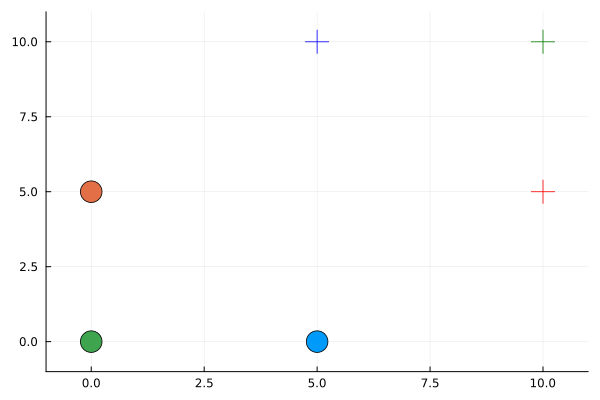

In [40]:
# Animation of the solution. GIF is saved in the assets folder.

anim = @animate for t in 1:length(X)
    scatter([X[t][1]], [X[t][2]], m = (:circle, 12),
    xlims = (-1, 11), 
    ylims = (-1, 11), 
    legend = false)
    scatter!([X[t][5]], [X[t][6]], m = (:circle, 12))
    scatter!([X[t][9]], [X[t][10]], m = (:circle, 12))
    plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12, :blue))
    plot!([xgoal[5]], [xgoal[6]], m = (:cross, 12, :red))
    plot!([xgoal[9]], [xgoal[10]], m = (:cross, 12, :green))
end every 1;
gif(anim, "assets/recedingHorizon.gif")

In [ ]:
# Trajectories of that the agents followed

plot([X[:][1]], [X[:][2]], xlims = (-1, 11), ylims = (-1, 11), legend = false)
plot!(X[:][5], X[:][6])
plot!(X[:][9], X[:][10])
plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12))
plot!([xgoal[5]], [xgoal[6]], m = (:cross, 12))
plot!([xgoal[9]], [xgoal[10]], m = (:cross, 12))

In [ ]:
# Agent 1's input values 
# y1: F in x 
# y2: F in y

plot(uₜ[:,1:2])

In [ ]:
# Agent 2's input values 
# y1: F in x 
# y2: F in y

plot(uₜ[:,3:4])

In [ ]:
# Agent 3's input values 
# y1: F in x 
# y2: F in y

plot(uₜ[:,5:6])